In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import fireducks.pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.simplefilter('ignore')

from src.utils.utils_fn import *
%load_ext autoreload
%autoreload 2

In [2]:
# Definir la ruta absoluta para la carpeta de pipelines
root_path = Path.cwd().resolve().parent

# Lectura del dataset preprocesado
data = pd.read_parquet(
    path=str(root_path / 'data/processed/data_final.parquet'), 
)

# Columnas innecesarias para el análisis exploratorio
target = 'canal_pedido_cd'
ids_cols = [col for col in data.columns if '_id' in col]
data = data.loc[:, [col for col in data.columns if col not in ids_cols]]
data.sample(5, random_state=10)

,pais_cd,region_comercial_txt,tipo_cliente_cd,madurez_digital_cd,estrellas_txt,frecuencia_visitas_cd,facturacion_usd_val,materiales_distintos_val,cajas_fisicas,fecha_pedido_dt,canal_pedido_cd
37674,SV,OCCIDENTE,TIENDA,MEDIA,2,L,501.90,32,65.78,2024-08-18,VENDEDOR
18391,PE,SUR,TIENDA,ALTA,3,LM,"1,139.17",74,137.41,2024-06-28,DIGITAL
45275,GT,METROPOLITANA,TIENDA,BAJA,2,LM,897.84,52,95.88,2024-07-25,DIGITAL
63239,GT,SUR,TIENDA,BAJA,1,L,"1,242.70",92,128.37,2024-06-03,VENDEDOR
63651,SV,CENTRO,MAYORISTA,MEDIA,2,LM,976.40,89,127.37,2024-05-24,DIGITAL


In [3]:

# Dimensiones del dataset
print(f'Número de muestras: {data.shape[0]}')
print(f'Predictores: {data.shape[1]}\n')
data.info()

Número de muestras: 149960
Predictores: 11

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149960 entries, 0 to 149959
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   pais_cd                   149960 non-null  object        
 1   region_comercial_txt      149960 non-null  object        
 2   tipo_cliente_cd           149960 non-null  object        
 3   madurez_digital_cd        149960 non-null  object        
 4   estrellas_txt             149960 non-null  int64         
 5   frecuencia_visitas_cd     149960 non-null  object        
 6   facturacion_usd_val       149960 non-null  float64       
 7   materiales_distintos_val  149960 non-null  int64         
 8   cajas_fisicas             149960 non-null  float64       
 9   fecha_pedido_dt           149960 non-null  datetime64[ns]
 10  canal_pedido_cd           149960 non-null  object        
dtypes: datetime64[ns](1),

In [4]:
# Función para capturar los tipos de variables
continuous, categoricals, discretes, temporaries = capture_variables(
    data=data.loc[:, data.columns != target]
)

In [5]:
# Convertir las variables discretas a tipo categórico
data[discretes] = data[discretes].astype('category')

In [6]:
# Graficando los valores faltantes
plotting_nan_values(
    data=data.loc[:, data.columns != target]
)

No se encontraron variables con nulos


In [7]:
# Resumen estadístico de variables continuas
data[continuous].describe().T

,count,mean,std,min,25%,50%,75%,max
facturacion_usd_val,"149,960.00","1,002.96",374.25,3.46,735.97,977.19,"1,240.80","3,024.49"
materiales_distintos_val,"149,960.00",62.52,24.55,1.00,45.00,61.00,78.00,230.00
cajas_fisicas,"149,960.00",100.26,37.44,0.04,73.38,97.68,124.05,352.72


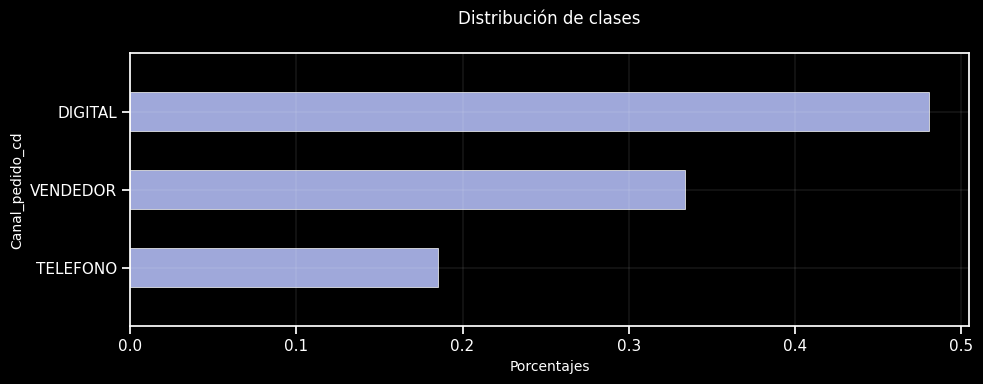

In [8]:
# Distribución de clases
class_distribution(
    data=data, 
    target=target
)

In [22]:
# Resumen estadístico de variables temporales
data[temporaries].describe().T

,count,mean,min,25%,50%,75%,max
fecha_pedido_dt,149960,2024-06-12 17:34:31.464390656,2023-01-01 00:00:00,2024-05-16 00:00:00,2024-07-05 00:00:00,2024-08-03 00:00:00,2024-08-23 00:00:00


In [9]:
# Agregaciones agrupadas por el target
for agg in ['mean', 'median', 'min', 'max', 'std']:
    display(data.groupby(target)[continuous].aggregate([agg]).T)

,canal_pedido_cd,DIGITAL,TELEFONO,VENDEDOR
facturacion_usd_val,mean,"1,002.01","1,000.30","1,005.82"
materiales_distintos_val,mean,62.50,62.30,62.67
cajas_fisicas,mean,100.18,100.08,100.48


,canal_pedido_cd,DIGITAL,TELEFONO,VENDEDOR
facturacion_usd_val,median,976.19,975.81,979.94
materiales_distintos_val,median,61.00,60.00,61.00
cajas_fisicas,median,97.53,97.60,97.97


,canal_pedido_cd,DIGITAL,TELEFONO,VENDEDOR
facturacion_usd_val,min,3.46,38.85,20.30
materiales_distintos_val,min,1.00,1.00,1.00
cajas_fisicas,min,0.04,0.78,0.98


,canal_pedido_cd,DIGITAL,TELEFONO,VENDEDOR
facturacion_usd_val,max,"3,024.49","2,934.31","2,983.57"
materiales_distintos_val,max,181.00,189.00,230.00
cajas_fisicas,max,287.66,289.50,352.72


,canal_pedido_cd,DIGITAL,TELEFONO,VENDEDOR
facturacion_usd_val,std,374.24,374.59,374.07
materiales_distintos_val,std,24.56,24.48,24.58
cajas_fisicas,std,37.46,37.62,37.31


In [10]:
# Agregaciones agrupadas por el target
for agg in ['count', 'nunique']:
    display(data.groupby(target)[categoricals + discretes].aggregate([agg]).T)

,canal_pedido_cd,DIGITAL,TELEFONO,VENDEDOR
pais_cd,count,72088,27804,50068
region_comercial_txt,count,72088,27804,50068
tipo_cliente_cd,count,72088,27804,50068
madurez_digital_cd,count,72088,27804,50068
frecuencia_visitas_cd,count,72088,27804,50068
estrellas_txt,count,72088,27804,50068


,canal_pedido_cd,DIGITAL,TELEFONO,VENDEDOR
pais_cd,nunique,4,4,4
region_comercial_txt,nunique,11,11,11
tipo_cliente_cd,nunique,3,3,3
madurez_digital_cd,nunique,3,3,3
frecuencia_visitas_cd,nunique,4,4,4
estrellas_txt,nunique,3,3,3


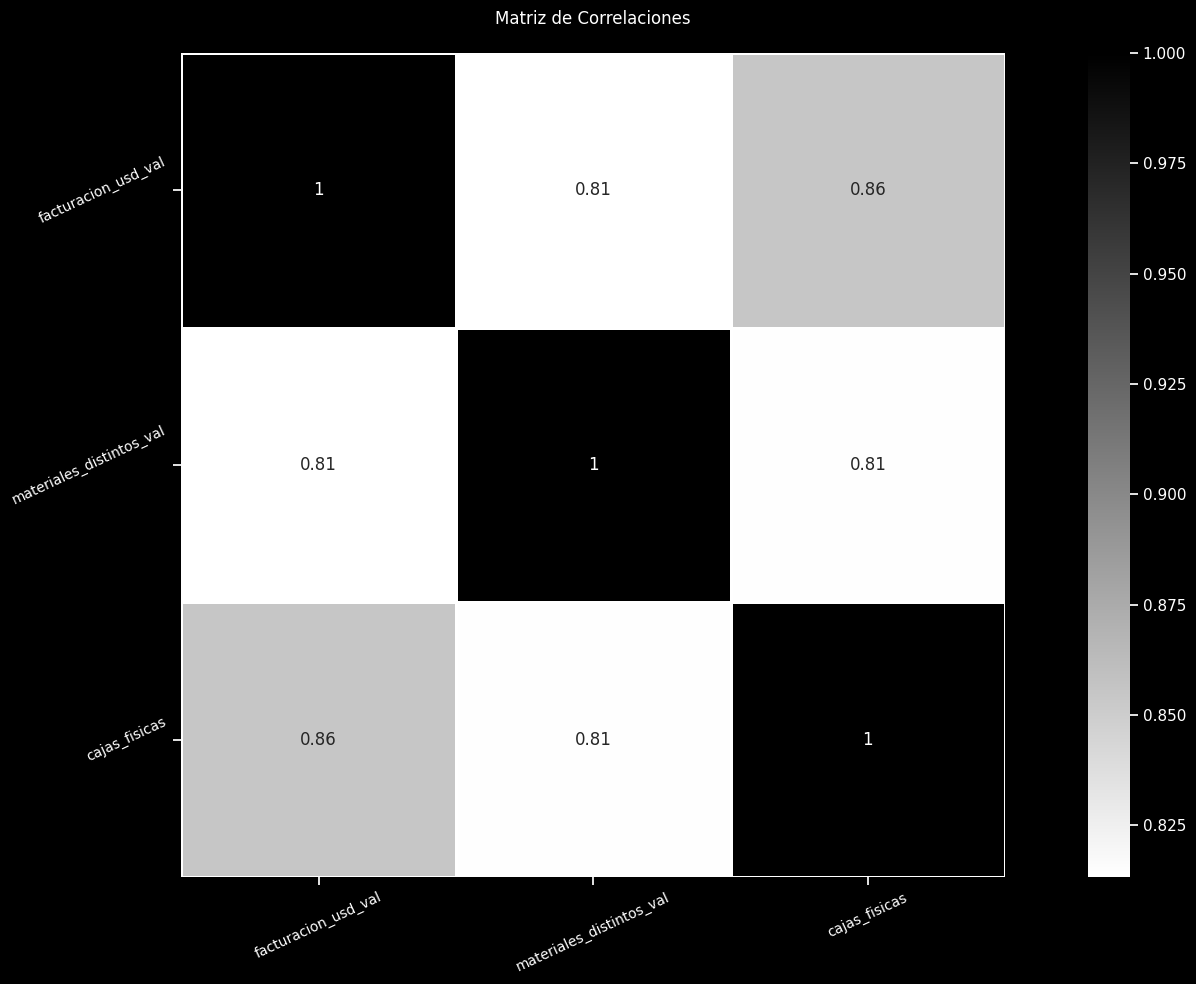

In [11]:
# Correlación entre predictores continuos
%matplotlib inline
continuous_correlation_matrix(
    data=data, 
    continuous=continuous
)

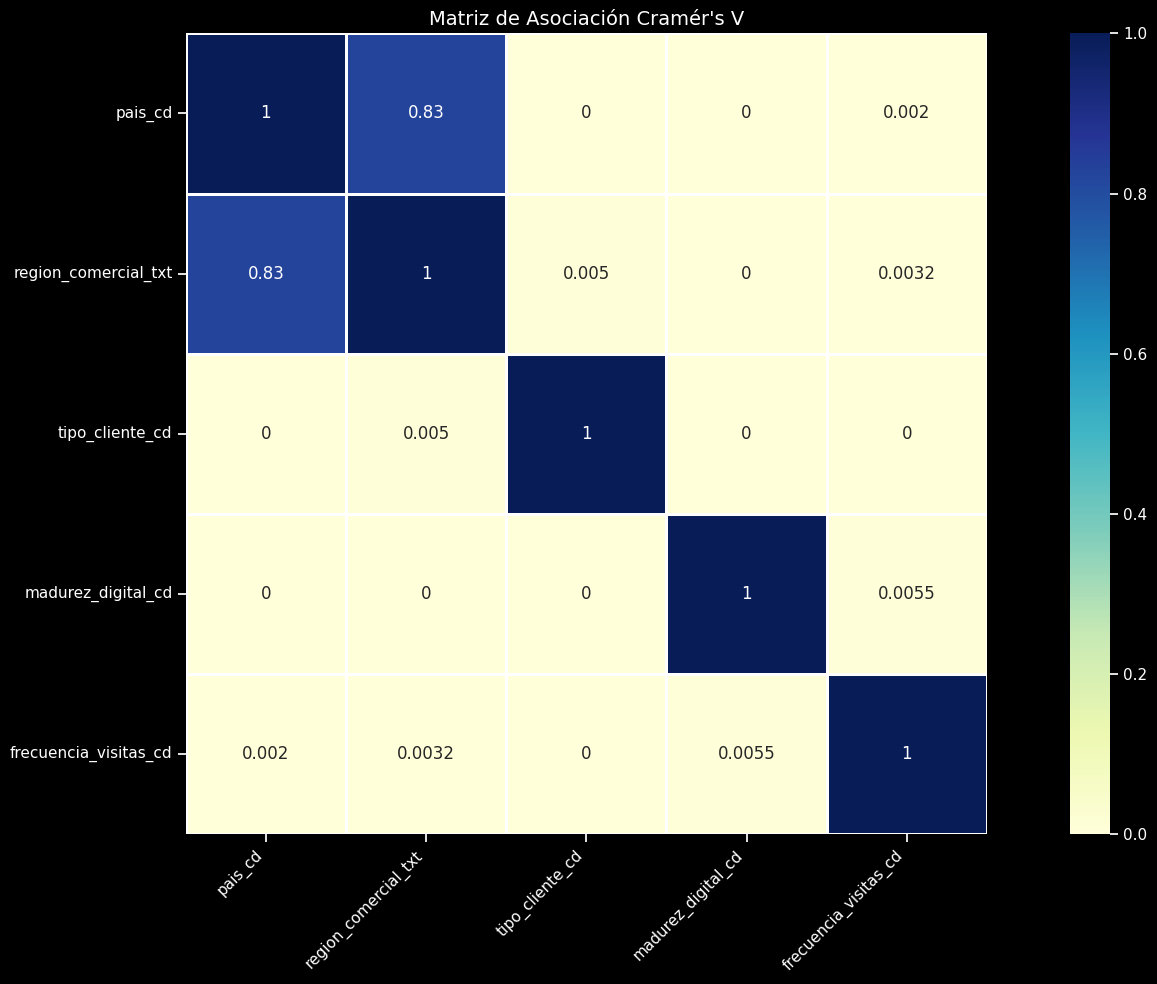

In [12]:
# Correlación entre predictores categóricos
%matplotlib inline
categoricals_correlation_matrix(
    data=data.loc[:, data.columns != target],
    categoricals=categoricals
)

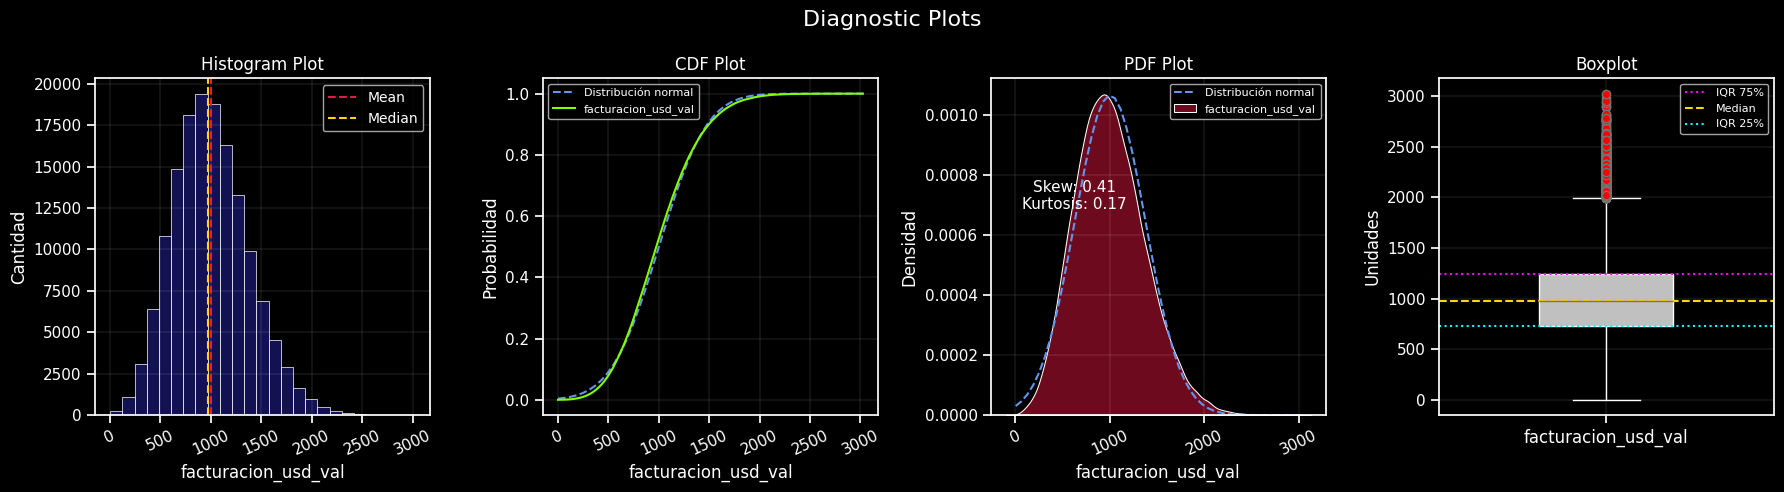

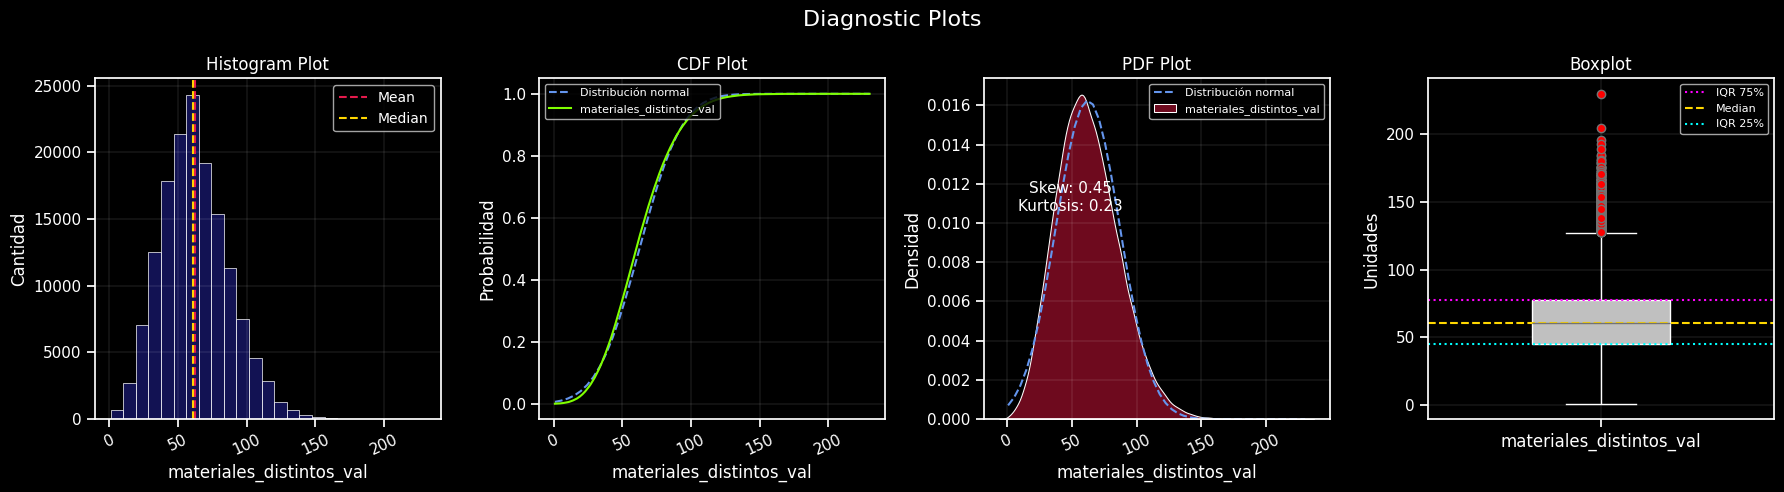

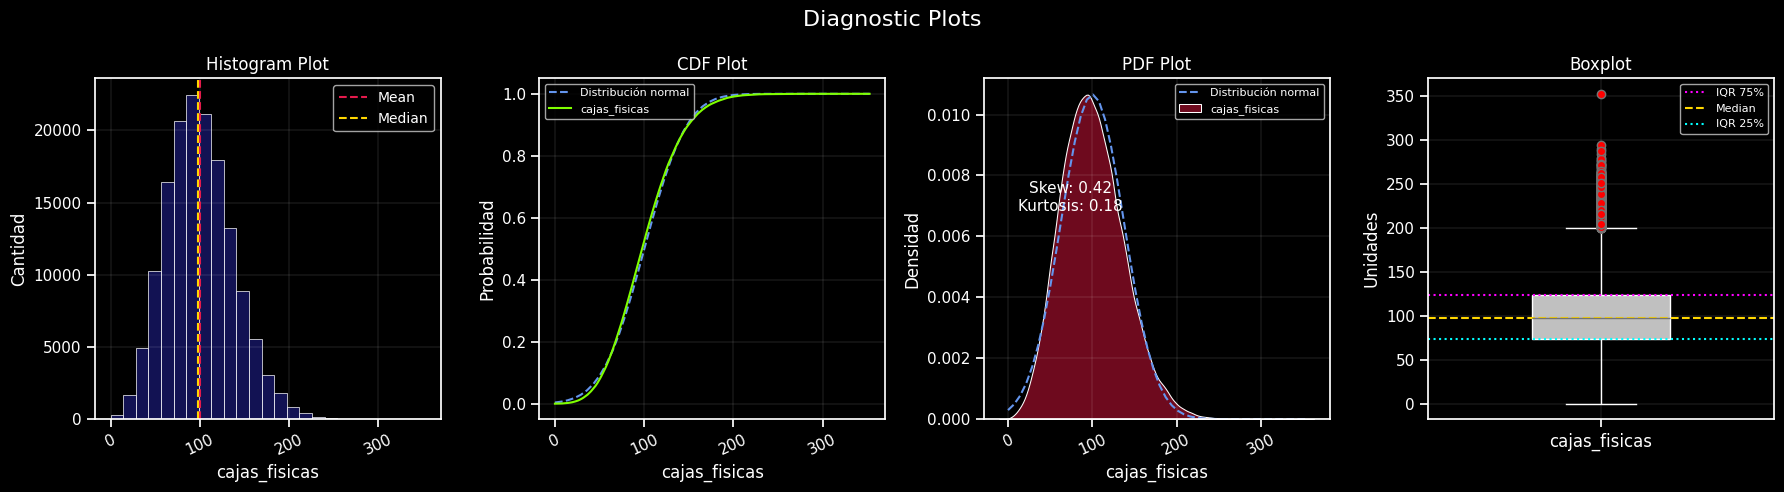

In [13]:
# Función para observar el comportamiento de variables continuas
diagnostic_plots(
    data=data.loc[:, data.columns != target], 
    variables=continuous
)

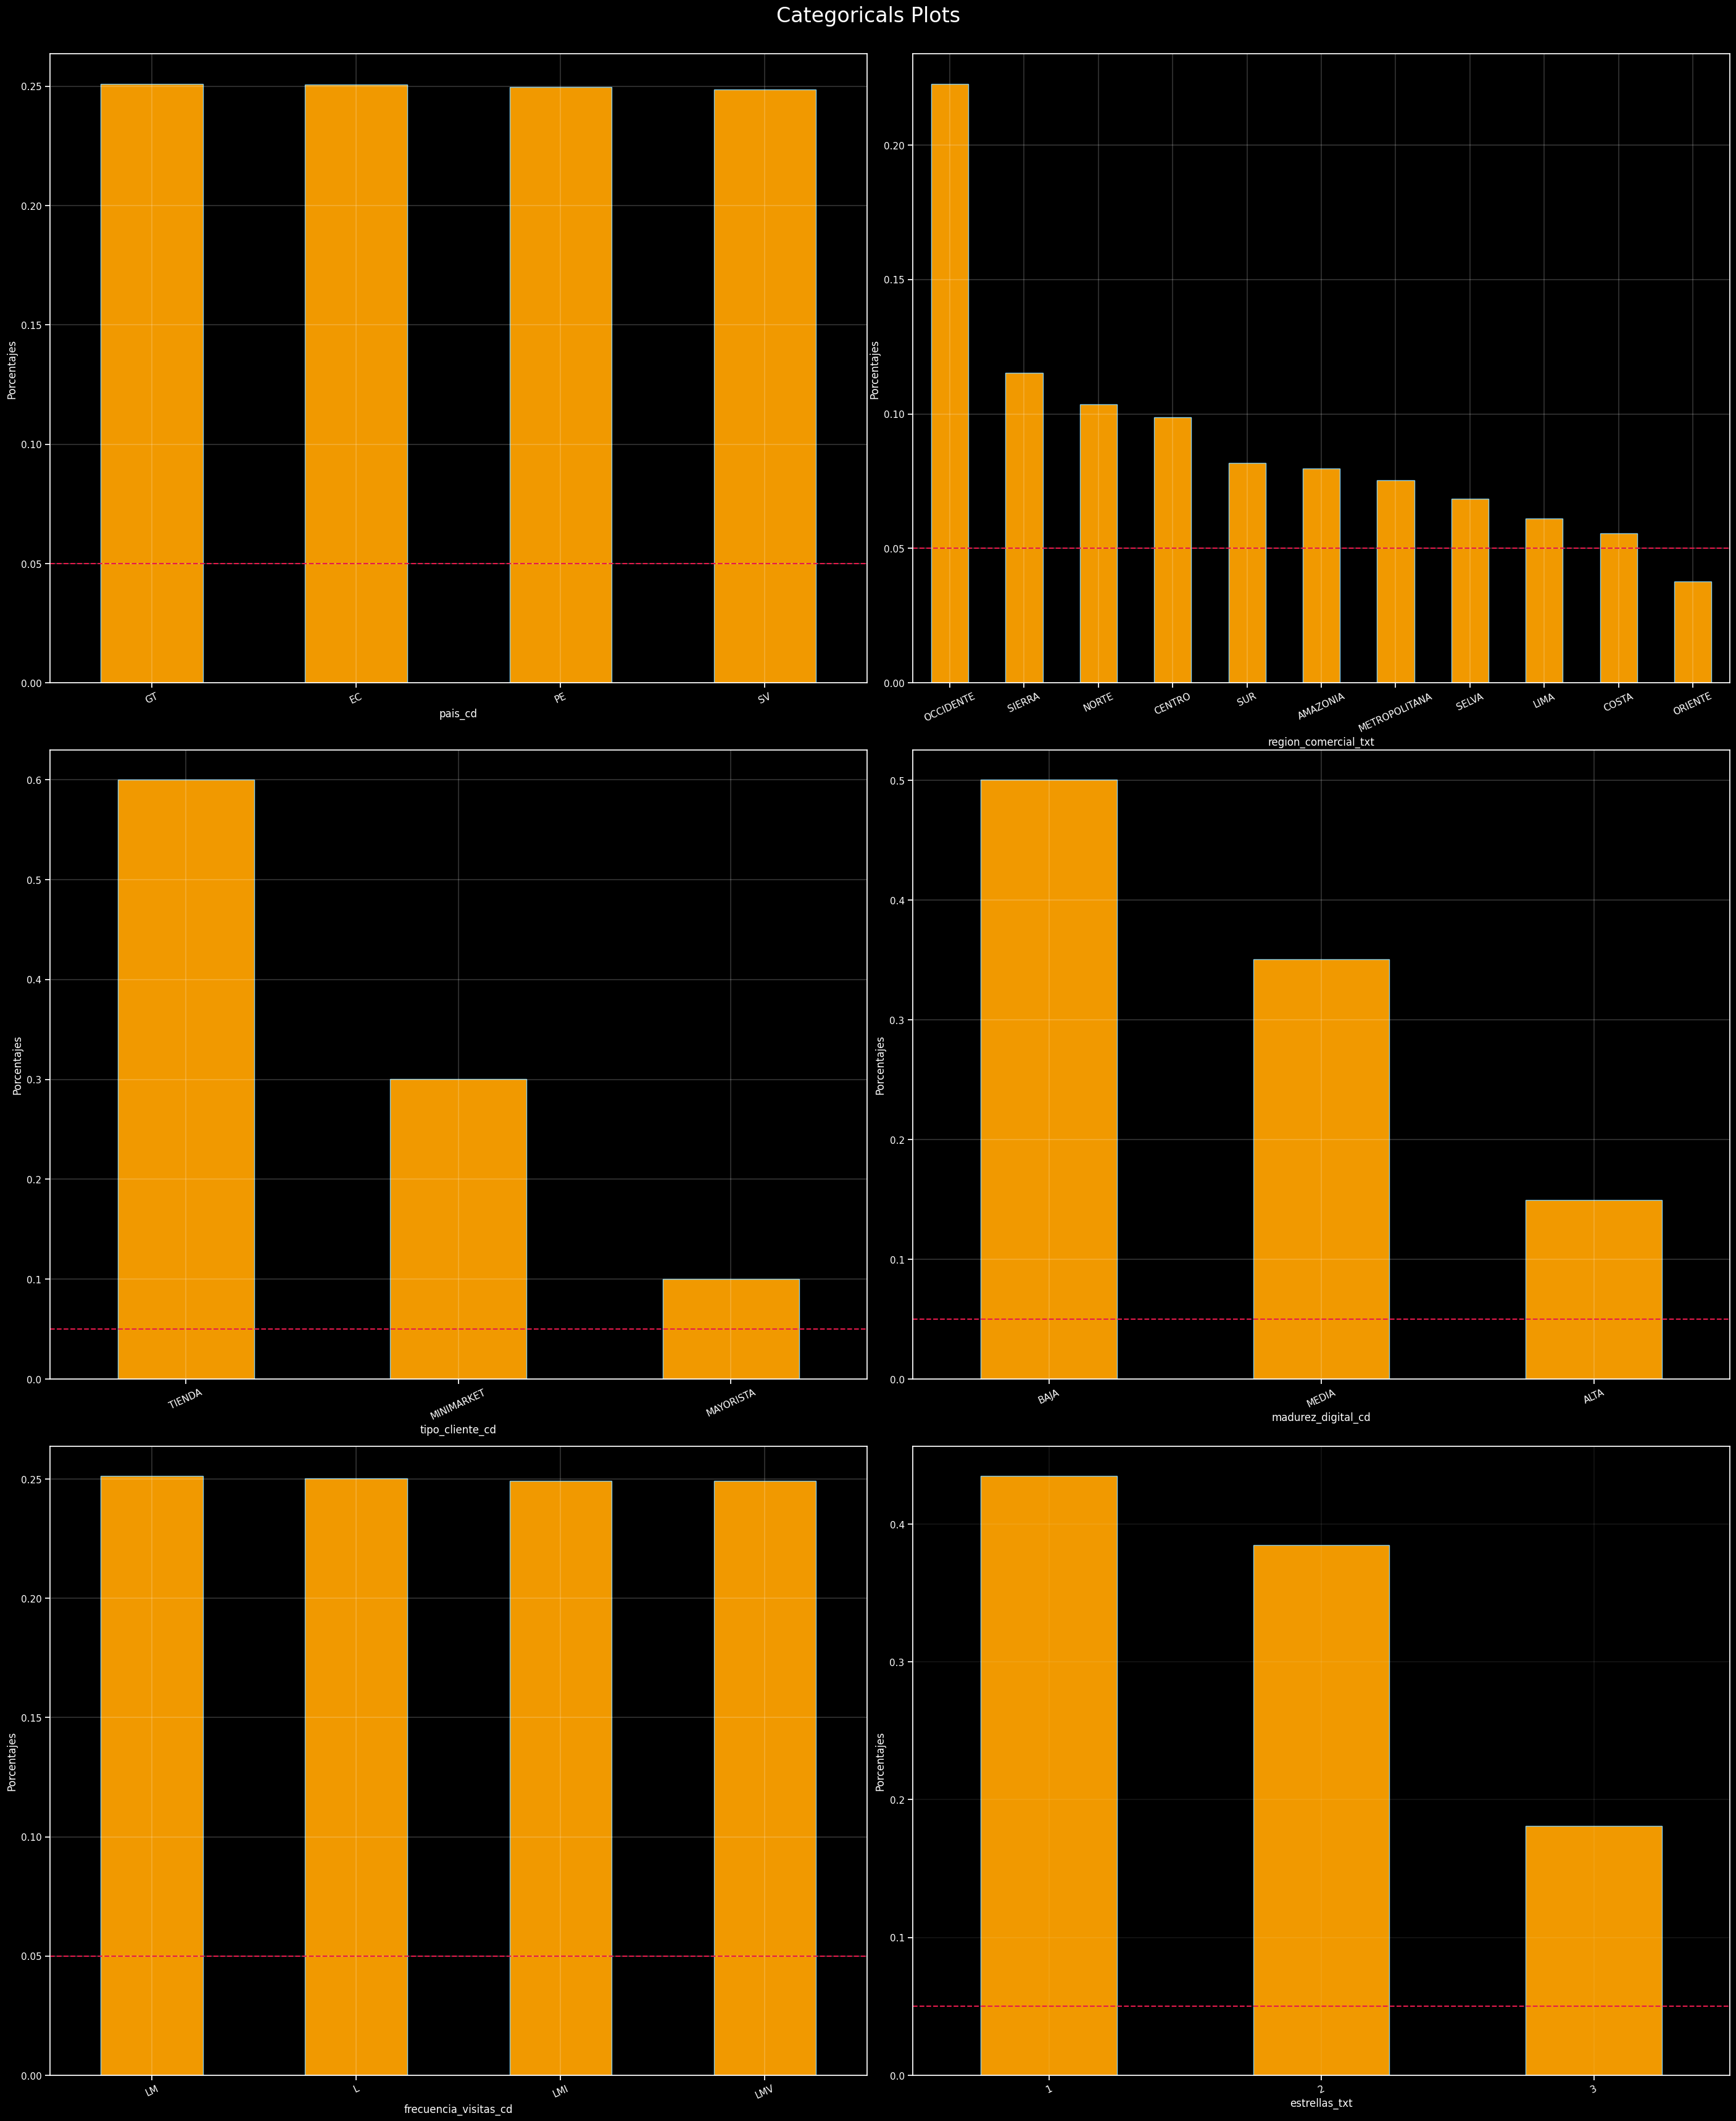

In [14]:
# Función para observar el comportamiento de variables categóricas
categoricals_plot(
    data=data.loc[:, data.columns != target], 
    variables=[var for var in categoricals + discretes if var in data.columns]
)

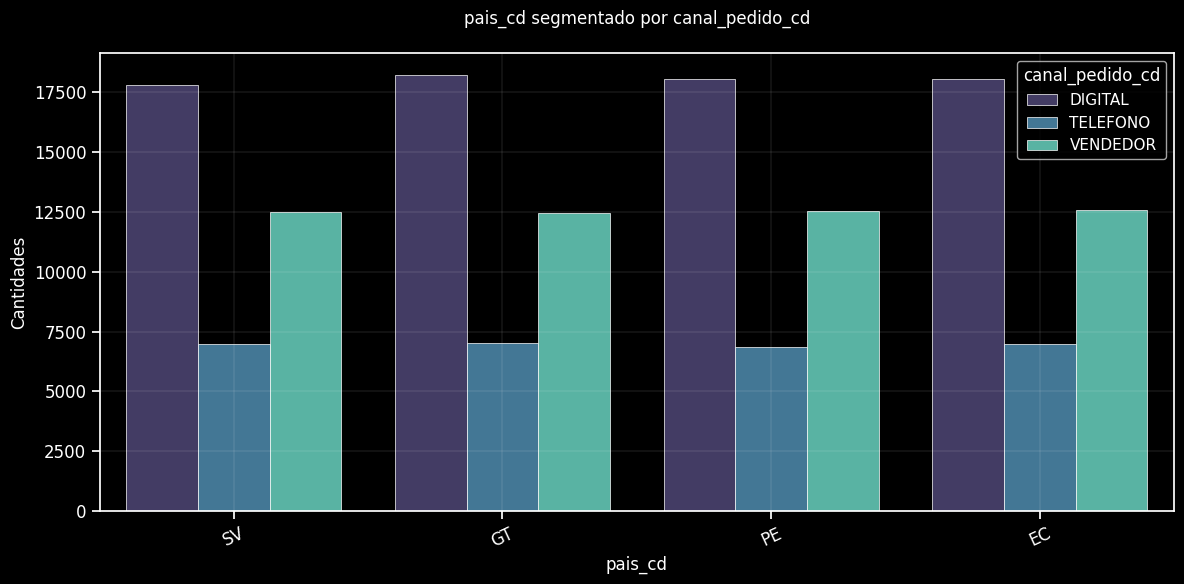

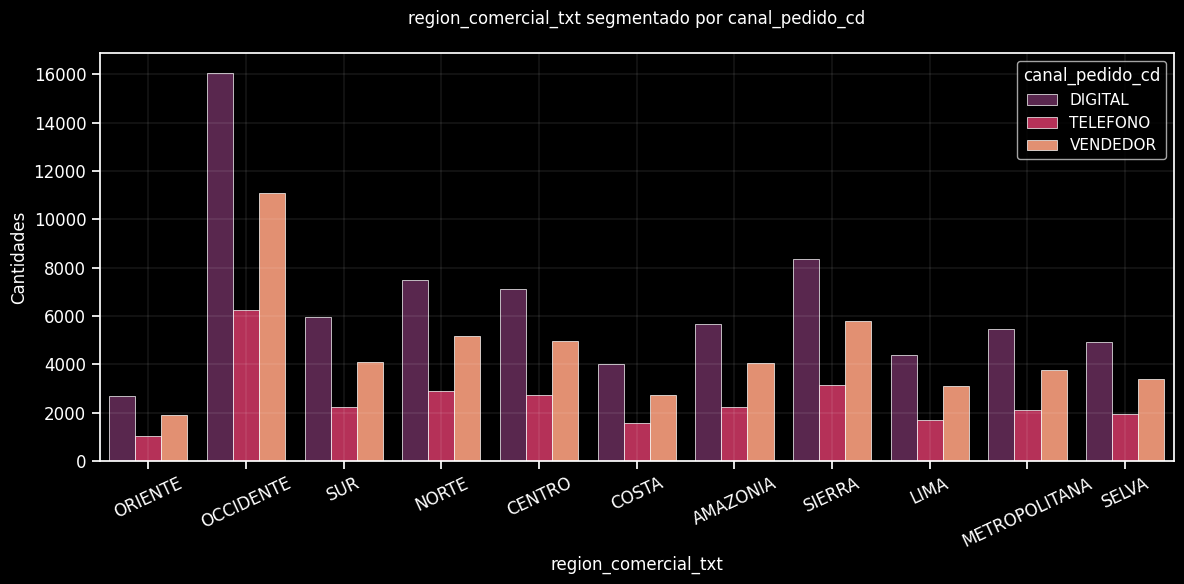

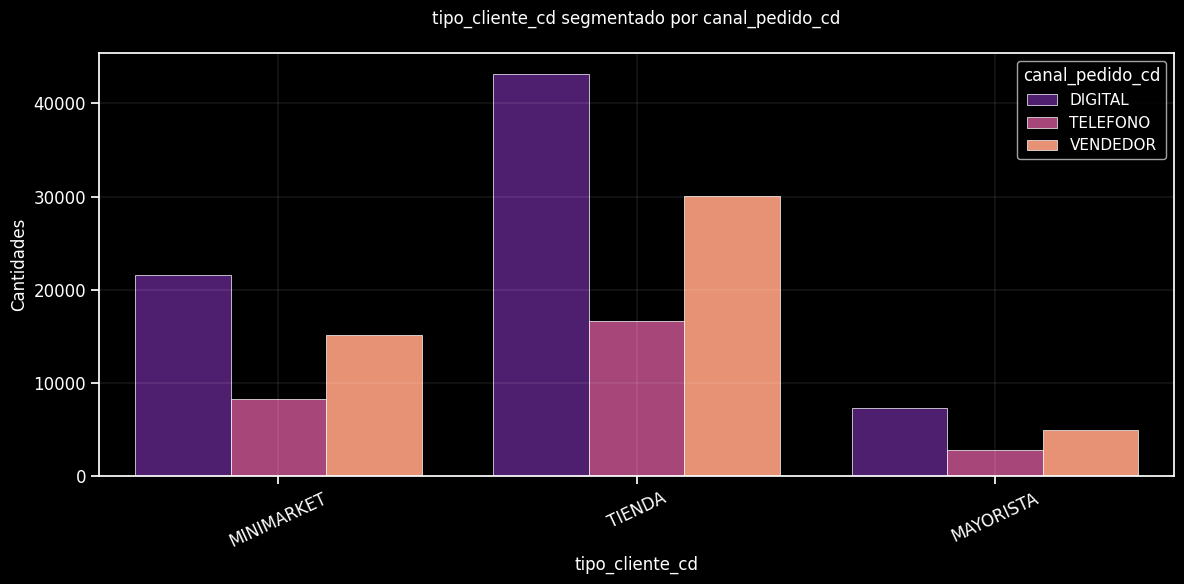

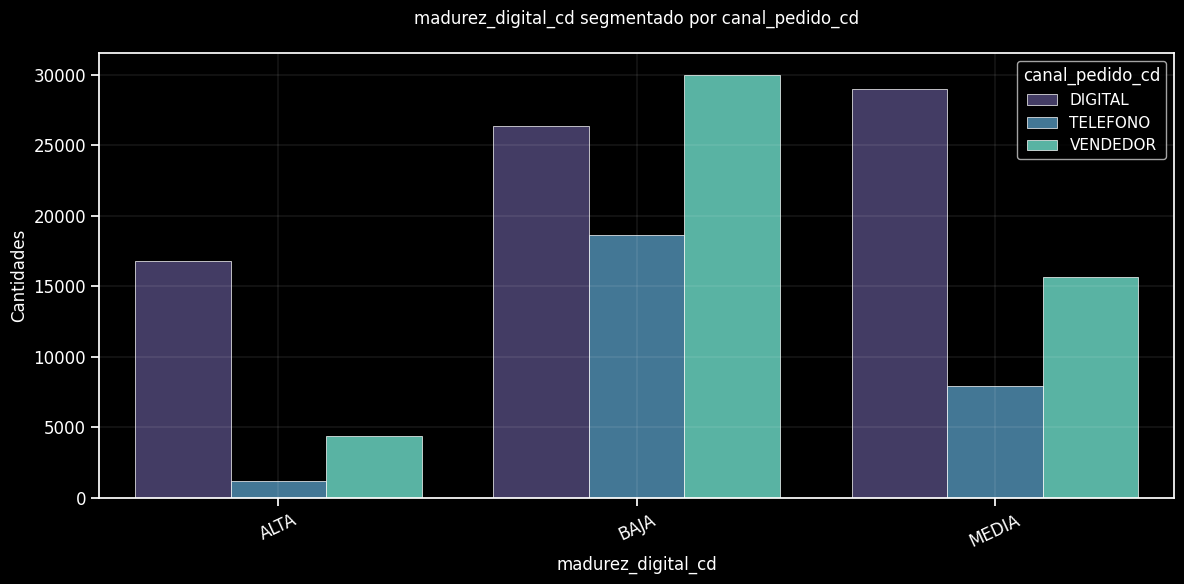

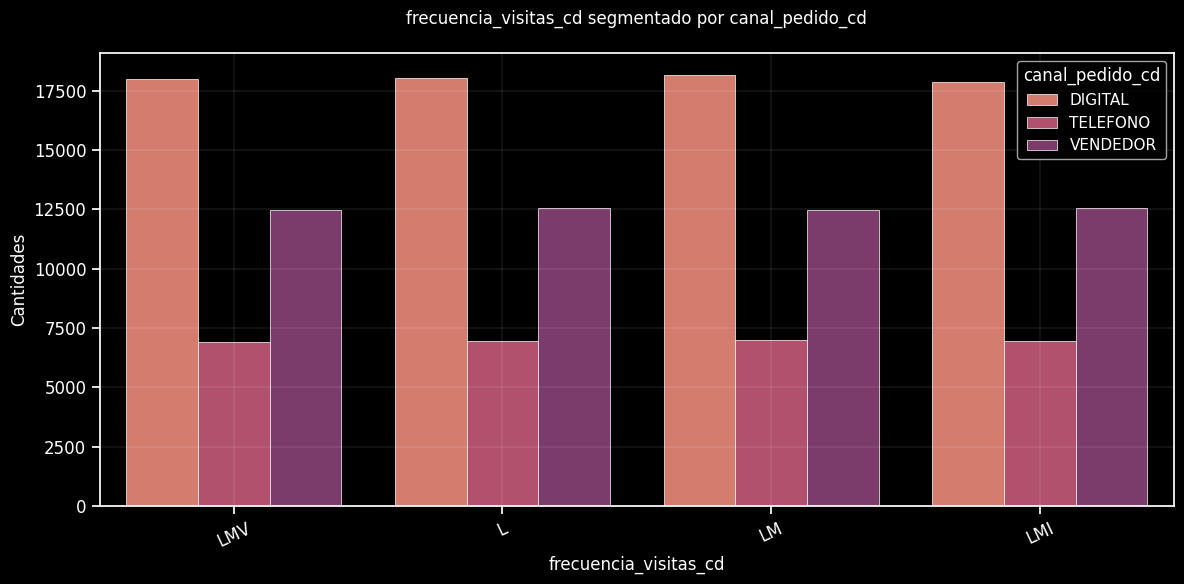

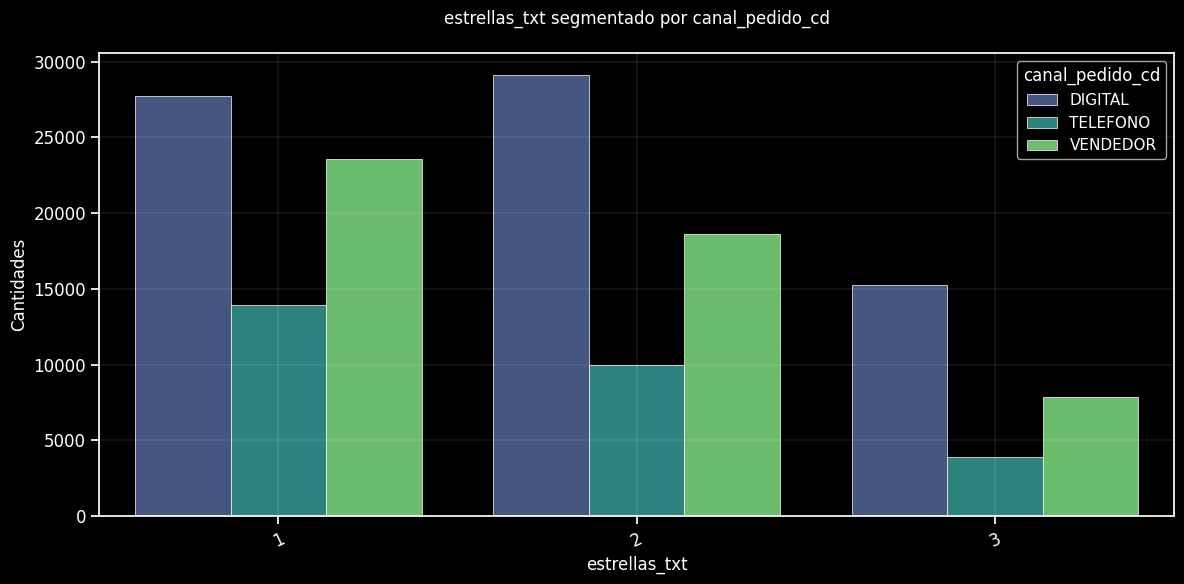

In [15]:
# Función para graficar las categóricas segmentadas por el target
categoricals_hue_target(
    data=data,
    variables=[var for var in categoricals + discretes if var in data.columns],
    target=target
)

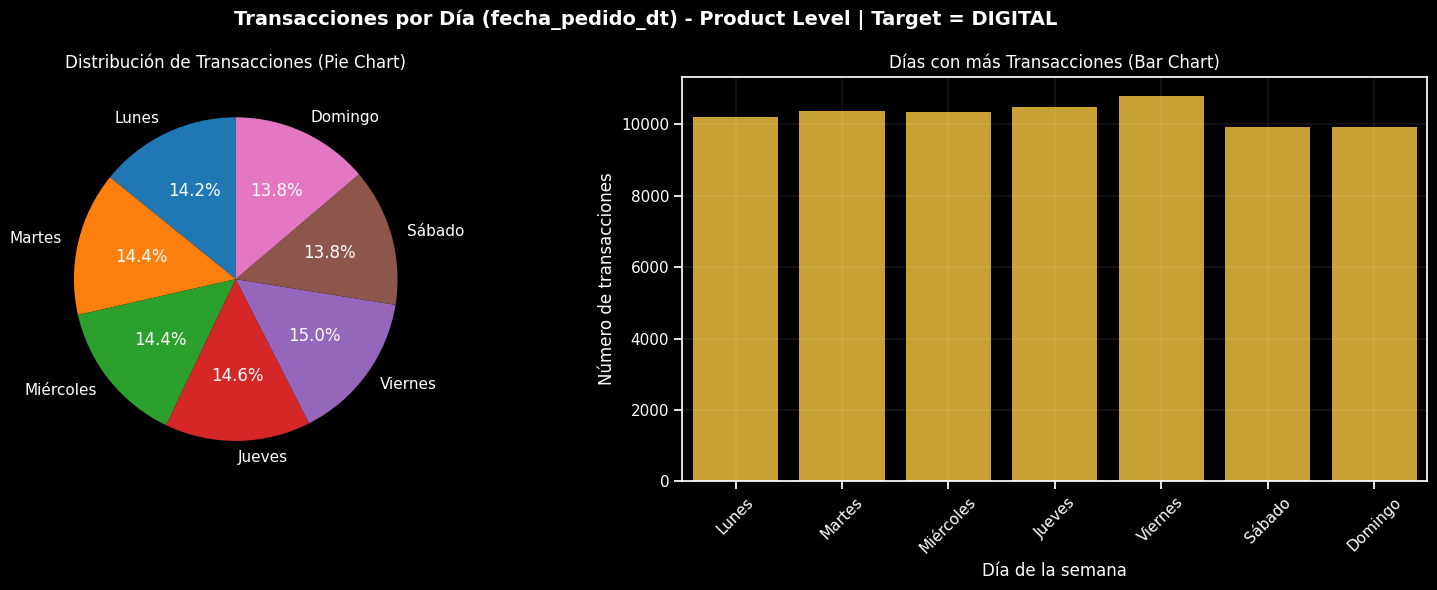

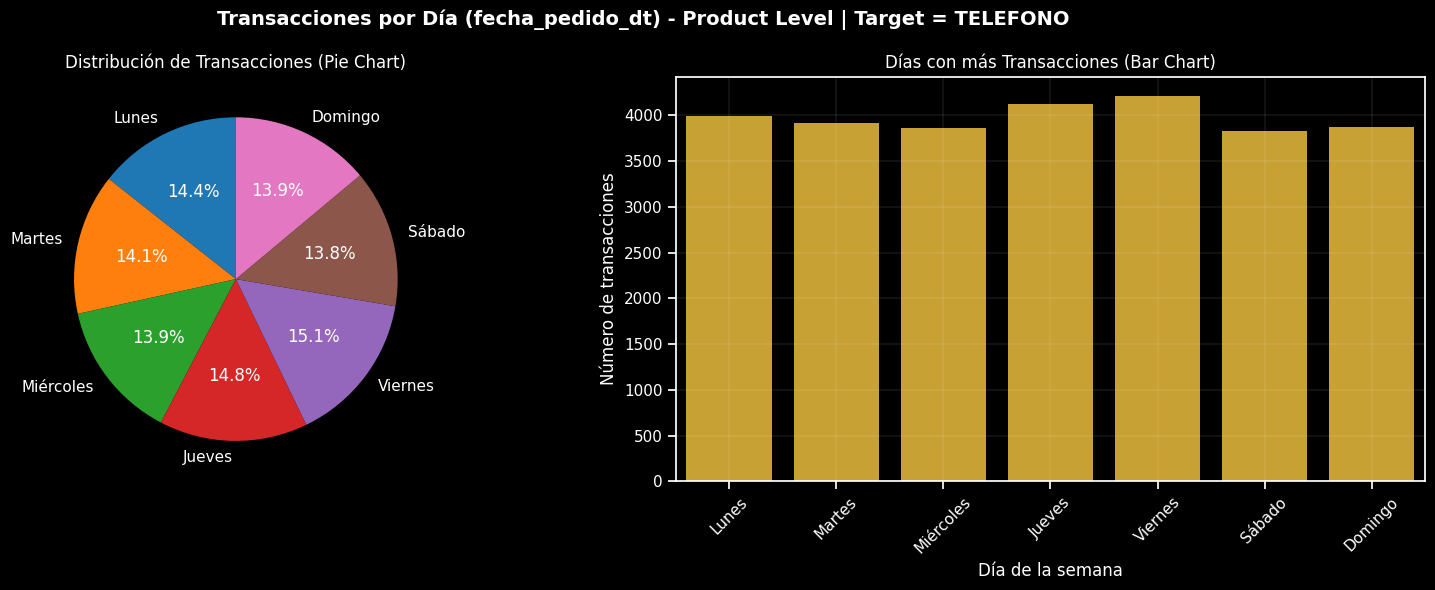

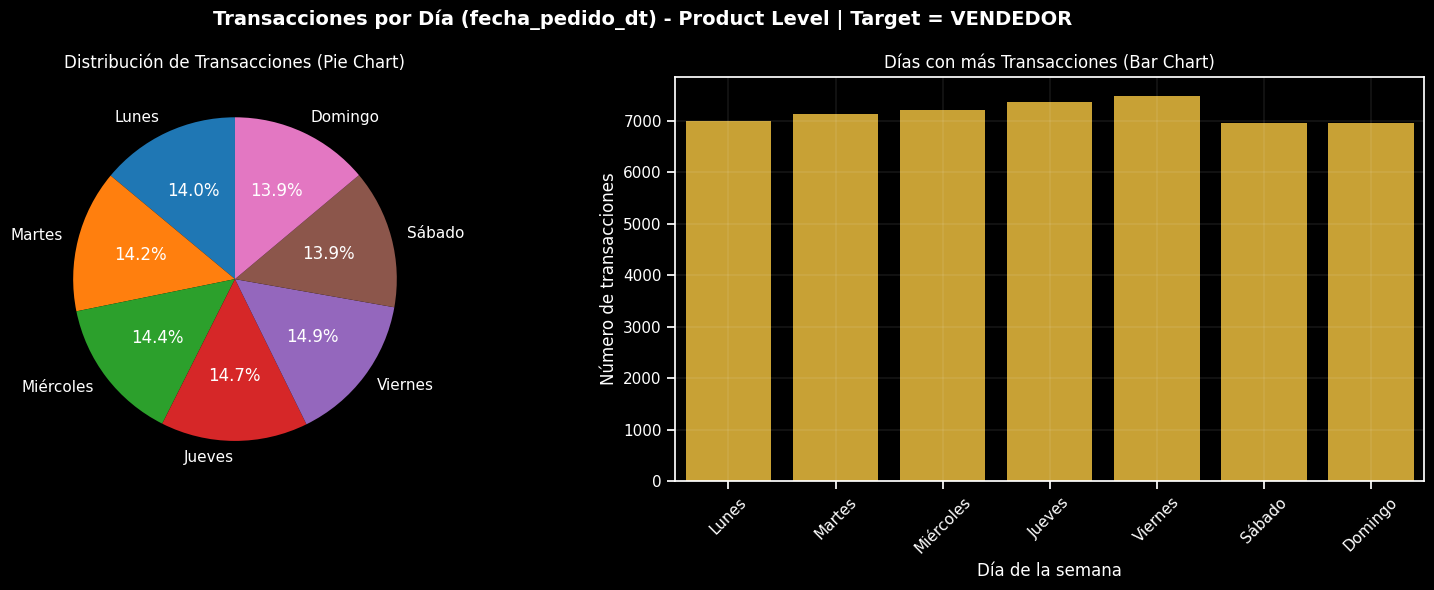

In [16]:
# Parámetros esperados
dataframes = {'Product Level': (data, '#E0AC1C')}
time_cols = ['fecha_pedido_dt']
day_translation = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
day_order = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

for title, (df_src, color) in dataframes.items():
    for time_col in time_cols:

        # categorías del target (sin NaN), en orden alfabético para reproducibilidad
        classes = (
            df_src[target]
            .dropna()
            .astype(str)
            .sort_values()
            .unique()
        )

        for cls in classes:
            # filtrar por categoría específica del target
            df_filtered = df_src.loc[df_src[target].astype(str) == str(cls)].copy()

            # asegurar tipo datetime y extraer día
            df_filtered[time_col] = pd.to_datetime(df_filtered[time_col], errors='coerce')
            df_filtered = df_filtered.dropna(subset=[time_col])
            df_filtered['day_of_week'] = (
                df_filtered[time_col]
                .dt.day_name()
                .map(day_translation)
            )

            # conteo por día y reindex para mantener el orden fijo de la semana
            weekday_counts = (
                df_filtered['day_of_week']
                .value_counts()
                .reindex(day_order, fill_value=0)
            )

            # crear figura: Pie + Bar para ESTA categoría del target
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(
                f"Transacciones por Día ({time_col}) - {title} | Target = {cls}",
                fontsize=14, fontweight='bold'
            )

            # Pie
            axes[0].pie(
                weekday_counts.values,
                labels=weekday_counts.index,
                autopct='%1.1f%%',
                startangle=90,
                colors=sns.color_palette('tab10', len(weekday_counts))
            )
            axes[0].set_title('Distribución de Transacciones (Pie Chart)', fontsize=12)

            # Barras
            sns.barplot(
                x=weekday_counts.index,
                y=weekday_counts.values,
                order=day_order,          # asegura el orden
                color=color,
                ax=axes[1]
            )
            axes[1].set_title('Días con más Transacciones (Bar Chart)', fontsize=12)
            axes[1].set_xlabel('Día de la semana')
            axes[1].set_ylabel('Número de transacciones')
            axes[1].tick_params(axis='x', rotation=45)
            axes[1].grid(color='white', linewidth=0.1)

            plt.tight_layout()
            plt.show()


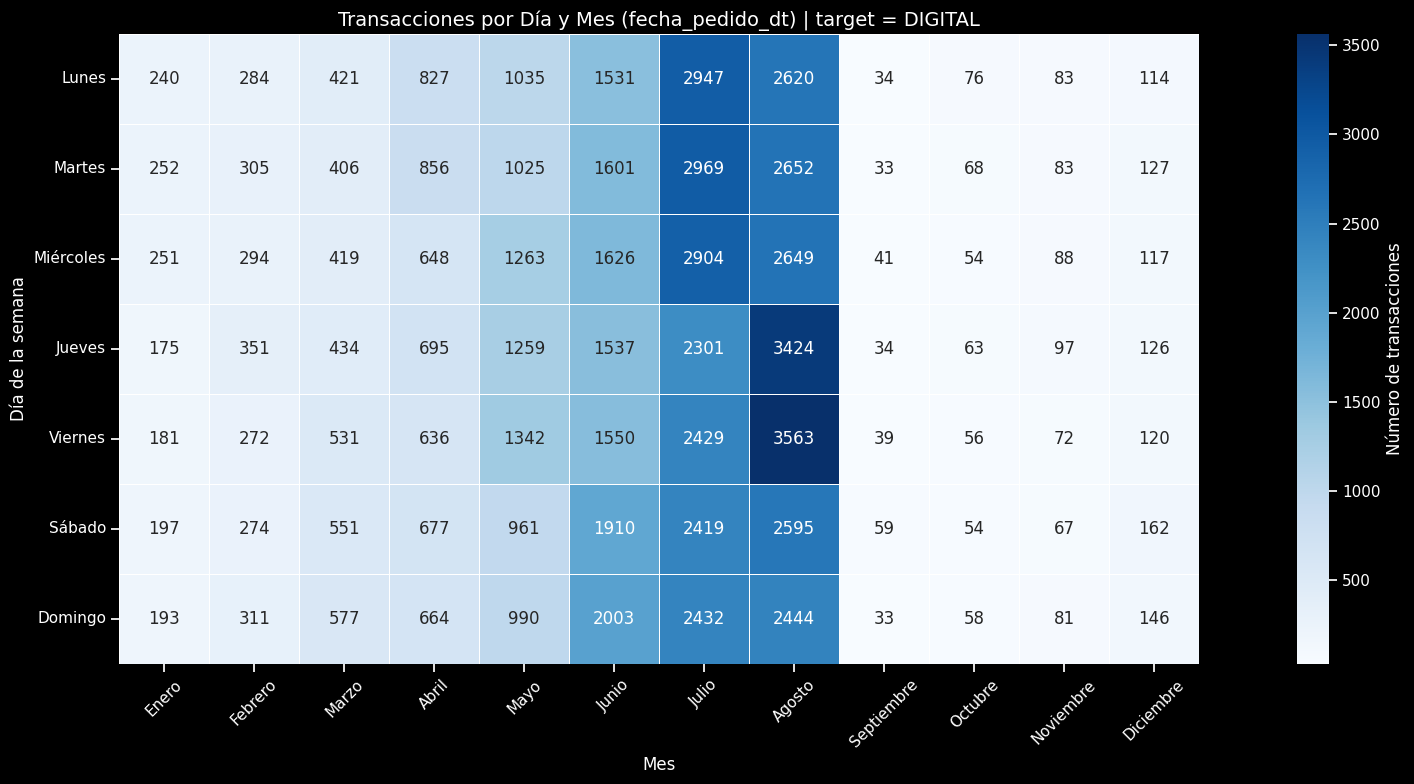

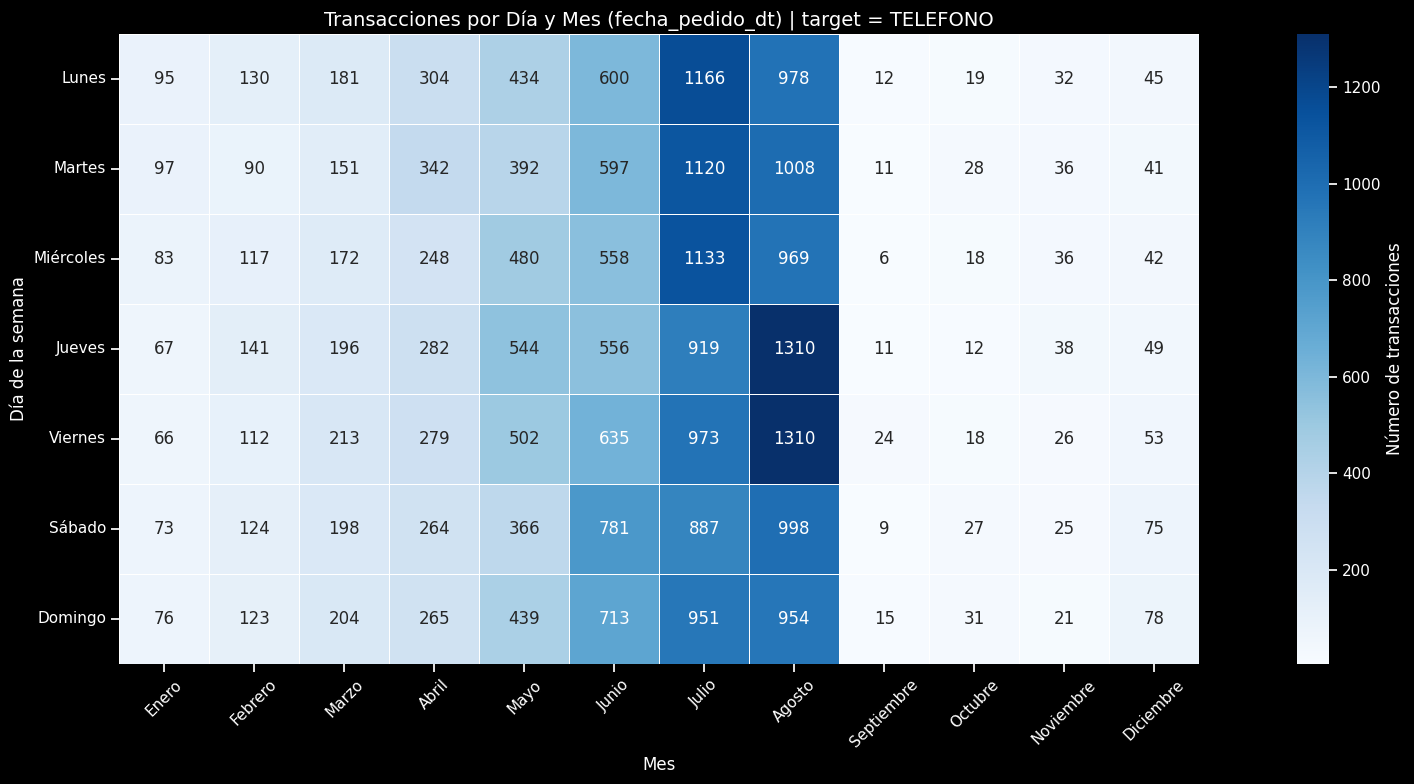

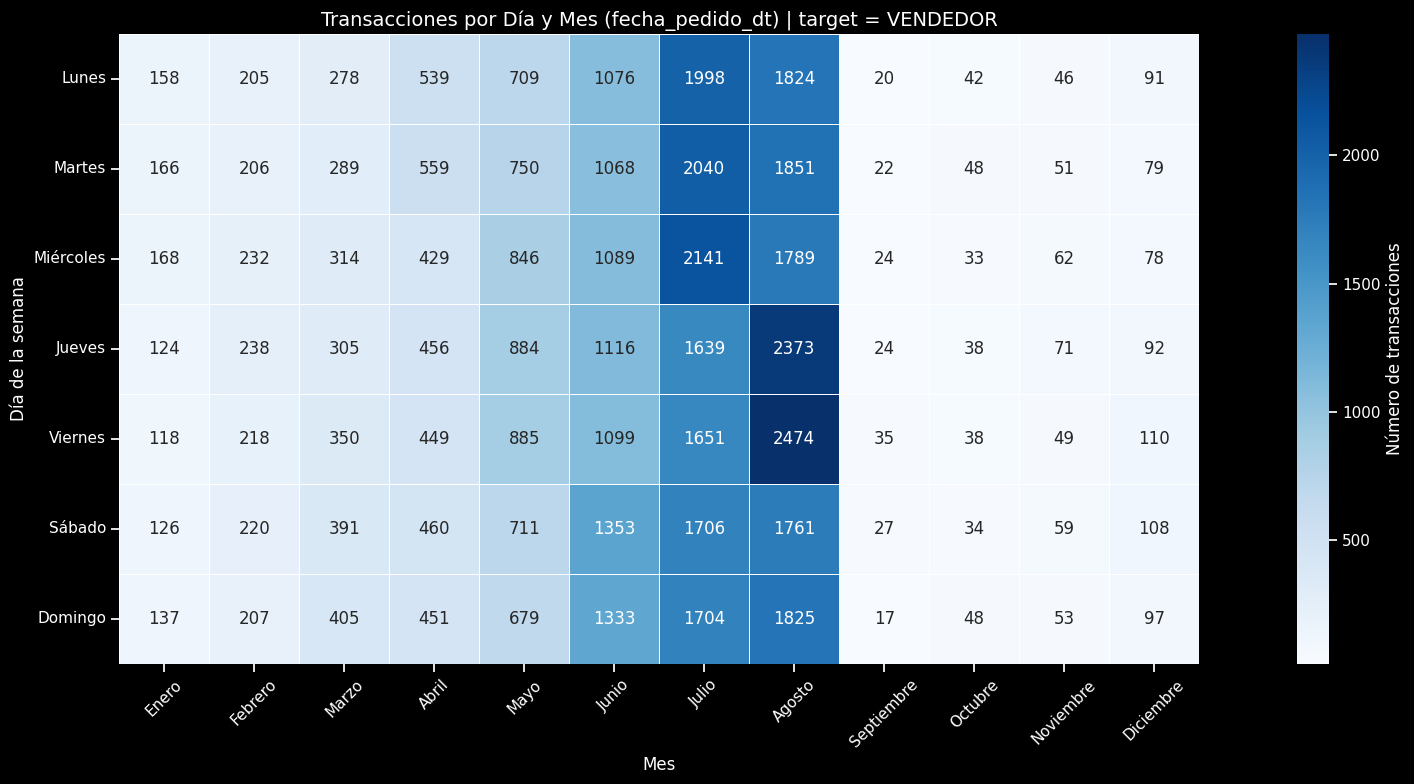

In [17]:
# Mapea número de mes a nombre en español y orden
month_names = {
    1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
    7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'
}
month_order = [month_names[m] for m in range(1, 13)]

cmap = 'Blues'

for time_col in time_cols:
    if time_col not in data.columns:
        continue

    # Asegurar datetime
    df_base = data.copy()
    df_base[time_col] = pd.to_datetime(df_base[time_col], errors='coerce')
    df_base = df_base.dropna(subset=[time_col])

    # Categorías del target
    classes = (
        df_base[target]
        .dropna()
        .astype(str)
        .sort_values()
        .unique()
    )

    for cls in classes:
        df_filtered = df_base.loc[df_base[target].astype(str) == str(cls)]
        if df_filtered.empty:
            continue

        # Día (ES) y Mes (ES)
        df_filtered = df_filtered.assign(
            day_of_week=df_filtered[time_col].dt.day_name().map(day_translation),
            month_name=df_filtered[time_col].dt.month.map(month_names)
        )

        # Tabla Día × Mes (conteo de transacciones)
        heatmap_data = (
            df_filtered.groupby(['day_of_week', 'month_name'])
                       .size()
                       .unstack(fill_value=0)
        )

        # Reordenar días y meses
        heatmap_data = heatmap_data.reindex(index=day_order, columns=month_order, fill_value=0)

        # Graficar
        plt.figure(figsize=(20, 8))
        sns.heatmap(
            heatmap_data,
            cmap=cmap,
            annot=True,
            square=True,
            fmt='d',
            linewidths=.5,
            cbar_kws={'label': 'Número de transacciones'}
        )
        plt.title(f'Transacciones por Día y Mes ({time_col}) | target = {cls}', fontsize=14)
        plt.xlabel('Mes', fontsize=12)
        plt.ylabel('Día de la semana', fontsize=12)
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()